In [3]:
#import libraries and warnings
import pandas as pd
import numpy as np
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplfinance as mpf

In [4]:
#reading the data: 'tick_data_es500_2013_10_02.bz2' pickle file as 'tick_data' dataframe
tick_data=pd.read_pickle('/Users/nirbhaiverma/Desktop/Quant/data/tick_data_es500_2013_10_02.bz2')

tick_data.head()

,bid,ask,trade_price,trade_size
,,,,
2013-10-02 00:00:00.604800,1428.50,1428.75,1428.75,1.0
2013-10-02 00:00:10.972800,1428.50,1428.75,1428.75,25.0
2013-10-02 00:00:19.439999,1428.50,1428.75,1429.00,17.0
2013-10-02 00:00:19.439999,1428.50,1428.75,1429.00,11.0
2013-10-02 00:00:19.526400,1428.75,1429.00,1429.00,28.0


In [16]:
#defining dollar bar's threshold-->Why dollar bars? bridges price gap volatility
threshold =100000

#Cum-Vol
tick_data['cumulative_volume']=tick_data['trade_size']*tick_data['trade_price'].cumsum()

In [17]:
#initisalisation
start_time= None
end_time=None
dollar_volume_sum=0
volume_sum=0
dollar_volume_bars_list=[]

#'time' to store timestamps of trade entries
tick_data['time']=pd.to_datetime(tick_data.index)

In [18]:
for index, row in tick_data.iterrows():
    
    if dollar_volume_sum ==0:
        start_time=row['time']
        
    volume_sum += row['trade_size']
    dollar_volume_sum += row['trade_size']*row['trade_price']
    
    if dollar_volume_sum >= threshold:
        end_time = row['time']
        
        #Creating a dict which contains OHLC data for current volume bar
        #if start_time in tick_data['time'].values and end_time in tick_data['time'].values:
        volume_data = {
            'start_time': start_time,
            'end_time': end_time,
            'open_price': tick_data.loc[tick_data['time']==start_time, 'trade_price'].iloc[0],# The 'open_price' key is set to the first value in the 'trade_price' column of the row where the 'time' column is equal to the 'start_time' variable
            'high_price': tick_data.loc[start_time:end_time, 'trade_price'].max(), # The 'high_price' key is set to the maximum value in the 'trade_price' column for rows  where the 'time' column is between the 'start_time' and 'end_time' variables
            'low_price': tick_data.loc[start_time:end_time, 'trade_price'].min(),
            'close_price': tick_data.loc[tick_data['time']==end_time,'trade_price'].iloc[0],
            'volume': volume_sum
        }

        dollar_volume_bars_list.append(volume_data)

        #now we caN reset the variables for teh calculation of next dollar volume bar

        start_time=None
        end_time=None
        dollar_volume_sum=0
        volume_sum=0
        
print(f'Total dollar volume bars created from {len(tick_data)} trades: {len(dollar_volume_bars_list)}')


Total dollar volume bars created from 77390 trades: 11655


In [19]:
#creating dataframe for dollar-volume bars
dollar_volume_bars = pd.DataFrame(dollar_volume_bars_list)
dollar_volume_bars.columns =['start_time','end_time','open', 'high', 'low','close','volume']

dollar_volume_bars.index = dollar_volume_bars.start_time

dollar_volume_bars.head()

,start_time,end_time,open,high,low,close,volume
start_time,,,,,,,
2013-10-02 00:00:00.604800,2013-10-02 00:00:00.604800,2013-10-02 00:00:19.526400,1428.75,1429.0,1428.75,1429.0,82.0
2013-10-02 00:00:19.612800,2013-10-02 00:00:19.612800,2013-10-02 00:03:11.894400,1429.00,1429.0,1428.75,1429.0,71.0
2013-10-02 00:03:13.449600,2013-10-02 00:03:13.449600,2013-10-02 00:04:16.521599,1429.00,1429.0,1428.75,1429.0,107.0
2013-10-02 00:04:16.521599,2013-10-02 00:04:16.521599,2013-10-02 00:05:12.249600,1429.00,1429.0,1428.00,1428.0,72.0
2013-10-02 00:05:12.336000,2013-10-02 00:05:12.336000,2013-10-02 00:08:20.515200,1428.25,1429.0,1428.00,1429.0,78.0


In [21]:
#Using Bulk Volume Classification for OrderFlow Calcultion

def bvc(data):
    # Calculate the price change
    data['price_change'] = data.close.diff()

    # Calculate volume-weighted price change
    data['vwp_change'] = (data['price_change'] * data['volume']).expanding().sum() / \
        data['volume'].expanding().sum()

    # Calculate rolling standard deviation of volume-weighted price change
    data['vwp_std'] = data['vwp_change'].expanding().std()

    # Calculate the buy volume and store it in the column 'buy_volume' in the dataframe 'data'
    data['buy_volume'] = data['volume'] * \
        ((data['price_change']/data['vwp_std'])
         .apply(lambda x: norm.cdf(x)))

    # Calculate the sell volume and store it in the column 'sell_volume' in the dataframe 'data'
    data['sell_volume'] = data['volume']-data['buy_volume']

    # Calculate the order flow and store it in the column 'order_flow' of the dataframe 'data'
    data['order_flow'] = data['buy_volume']-data['sell_volume']

    # Select columns for the order flow dataframe and drop rows with any missing data
    data = data[['close', 'buy_volume', 'sell_volume', 'order_flow']]
    data = data.dropna()
    
    return data

In [22]:
# Calculate the order flow using the bvc function and store it in `volume_bars`
dollar_volume_bars = bvc(dollar_volume_bars)

# Print the first 20 rows of the dataframe `volume_bars`
dollar_volume_bars.head(20)

,close,buy_volume,sell_volume,order_flow
start_time,,,,
2013-10-02 00:04:16.521599,1428.00,4.990419e-14,72.000000,-72.000000
2013-10-02 00:05:12.336000,1429.00,7.800000e+01,0.000000,78.000000
2013-10-02 00:08:53.606400,1429.00,3.550000e+01,35.500000,0.000000
2013-10-02 00:11:30.076799,1429.00,7.500000e+01,75.000000,0.000000
2013-10-02 00:13:21.878400,1429.00,7.150000e+01,71.500000,0.000000
2013-10-02 00:16:15.369600,1428.25,1.285573e-19,71.000000,-71.000000
2013-10-02 00:22:43.910400,1428.00,3.309576e-02,69.966904,-69.933808
2013-10-02 00:22:48.748799,1428.00,5.650000e+01,56.500000,0.000000
2013-10-02 00:23:22.012800,1428.00,3.600000e+01,36.000000,0.000000


In [23]:

# Calculate the cumulative order flow and store it in the column 'cumulative_order_flow'
dollar_volume_bars['cumulative_order_flow'] = dollar_volume_bars['order_flow'].cumsum()

# Initialise the variable pos to 0, which will be used to keep track of the current position
pos = 0

# Create an empty Pandas DataFrame called 'trades' to save trade details
columns = ['entry_time', 'exit_time', 'direction', 'entry_price', 'exit_price', 'trade_return']
trades = pd.DataFrame(columns=columns)

# Create a list of all indices in the dataframe and store it in `indices_total`
indices = dollar_volume_bars.index.tolist()

# Remove duplicate entries from the dollar_volume_bars dataframe, keeping only the first occurrence of each duplicated index value.
dollar_volume_bars = dollar_volume_bars[~dollar_volume_bars.index.duplicated(keep='first')]

# Define the lookback for the dollar volume bars
lookback = 20

# Define additional parameters for risk management and dynamic threshold adjustments
risk_per_trade = 0.02  # Risk 2% of capital per trade
initial_capital = 100000  # Initial capital
position_size = initial_capital * risk_per_trade

# Define parameters for moving average calculation
ma_window = 10

# Looping over the indices filtered
for i in range(lookback, len(indices)):

    # Set the current index to the i-1 th index of the 'indices' list
    current_index = indices[i-1]

    # Set the start index to lookback bars before the current index
    start_index = indices[i-lookback]

    # Find all indices within the previous lookback bars from the index of the current row
    indices_within_lookback_bars = [
        j for j in indices if j >= start_index and j < current_index]

    # Calculate the net order flow by taking the difference between the cumulative order flow at the beginning and end of the lookback period
    order_flow = (dollar_volume_bars.loc[indices_within_lookback_bars].cumulative_order_flow.iloc[-1]) - (dollar_volume_bars.loc[indices_within_lookback_bars].cumulative_order_flow.iloc[0])
    
     # Calculate various order flow thresholds based on percentiles
    # long_entry_threshold: 75th percentile of order flow in the lookback period as the threshold for the long entry
    long_entry_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 75)

    # long_exit_threshold: 50th percentile of order flow in the lookback period as the stop-loss threshold for the long exit
    long_exit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 50)

    # long_takeprofit_threshold: 90th percentile of order flow in the lookback period as the take-profit threshold for the long exit
    long_takeprofit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 90)

    # short_entry_threshold: 25th percentile of order flow in the lookback period as the threshold for the short entry
    short_entry_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 25)

    # short_exit_threshold: 50th percentile of order flow in the lookback period as the stop-loss threshold for the short exit
    short_exit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 50)

    # short_takeprofit_threshold: 10th percentile of order flow in the lookback period as the take-profit threshold for the short exit
    short_takeprofit_threshold = np.percentile(
        dollar_volume_bars.loc[start_index:current_index].order_flow, 10)
    
    # Additional: Calculate a simple moving average of order flow
    ma_order_flow = dollar_volume_bars.loc[indices_within_lookback_bars].order_flow.rolling(window=ma_window).mean().iloc[-1]

    # Check if there are any open positions
    if pos == 0:

        # Check if the net order flow is strong and positive, and above the moving average
        if order_flow > long_entry_threshold and order_flow < long_takeprofit_threshold and order_flow > ma_order_flow:

            # Enter long position
            entry_time = indices[i]
            entry_price = dollar_volume_bars.loc[indices[i]].close
            pos = 1

        # Check if the net order flow is weak and negative, and below the moving average
        elif order_flow < short_entry_threshold and order_flow > short_takeprofit_threshold and order_flow < ma_order_flow:

            # Enter short position
            entry_time = indices[i]
            entry_price = dollar_volume_bars.loc[indices[i]].close
            pos = -1

    # Check if there is an open long position
    elif pos > 0:

        # Check if the net order flow has fallen below the exit threshold or risen above the take profit threshold
        if order_flow <= long_exit_threshold or order_flow >= long_takeprofit_threshold:

            # Exit long position
            exit_time = indices[i]
            exit_price = dollar_volume_bars.loc[indices[i]].close
            trade_return = (exit_price / entry_price - 1) * pos
            initial_capital += initial_capital * trade_return

            # Adding trade to trades dataframe
            trade_details = [entry_time, exit_time, 1, entry_price, exit_price, trade_return]
            trades.loc[entry_time] = trade_details
            pos = 0

    # Check if there is an open short position
    elif pos < 0:

        # Check if the net order flow has risen above the exit threshold or fallen below the take profit threshold
        if order_flow >= short_exit_threshold or order_flow <= short_takeprofit_threshold:

            # Exit short position
            exit_time = indices[i]
            exit_price = dollar_volume_bars.loc[indices[i]].close
            trade_return = (entry_price / exit_price - 1) * abs(pos)
            initial_capital += initial_capital * trade_return

            # Adding trade to trades dataframe
            trade_details = [entry_time, exit_time, -1, entry_price, exit_price, trade_return]
            trades.loc[entry_time] = trade_details
            pos = 0

# Display the trades dataframe
print(trades)



                                           entry_time  \
2013-10-02 00:55:18.537600 2013-10-02 00:55:18.537600   
2013-10-02 01:01:19.603200 2013-10-02 01:01:19.603200   
2013-10-02 01:55:36.969600 2013-10-02 01:55:36.969600   
2013-10-02 01:59:45.715200 2013-10-02 01:59:45.715200   
2013-10-02 02:08:21.350400 2013-10-02 02:08:21.350400   
...                                               ...   
2013-10-02 23:14:14.294400 2013-10-02 23:14:14.294400   
2013-10-02 23:20:24.345600 2013-10-02 23:20:24.345600   
2013-10-02 23:30:38.908799 2013-10-02 23:30:38.908799   
2013-10-02 23:39:43.315200 2013-10-02 23:39:43.315200   
2013-10-02 23:53:46.233599 2013-10-02 23:53:46.233599   

                                            exit_time  direction  entry_price  \
2013-10-02 00:55:18.537600 2013-10-02 00:55:52.060799         -1       1428.0   
2013-10-02 01:01:19.603200 2013-10-02 01:15:10.080000         -1       1428.0   
2013-10-02 01:55:36.969600 2013-10-02 01:58:10.156800          1       1

In [26]:
#Performance Analysis
trades['pnl']=trades.direction*(trades.exit_price - trades.entry_price)

#returns of each trade
trades['returns']=100*trades['pnl']/trades['entry_price']

#Print last 5 trades
trades.tail()

,entry_time,exit_time,direction,entry_price,exit_price,trade_return,pnl,returns
2013-10-02 23:14:14.294400,2013-10-02 23:14:14.294400,2013-10-02 23:16:00.825600,-1,1439.0,1438.50,0.000348,0.50,0.034746
2013-10-02 23:20:24.345600,2013-10-02 23:20:24.345600,2013-10-02 23:24:57.888000,1,1438.5,1438.50,0.000000,0.00,0.000000
2013-10-02 23:30:38.908799,2013-10-02 23:30:38.908799,2013-10-02 23:35:28.435200,-1,1439.0,1439.00,0.000000,-0.00,-0.000000
2013-10-02 23:39:43.315200,2013-10-02 23:39:43.315200,2013-10-02 23:44:03.379200,-1,1439.0,1438.25,0.000521,0.75,0.052120
2013-10-02 23:53:46.233599,2013-10-02 23:53:46.233599,2013-10-02 23:54:03.859200,-1,1438.0,1438.00,0.000000,-0.00,-0.000000


In [27]:
# Calculate the cumulative return
cumulative_return = (1 + trades['returns']).cumprod() - 1

# Print cumulative returns of the strategy
print(
    f'Cumulative returns of the strategy: {np.round(cumulative_return[-1],4)} %')

Cumulative returns of the strategy: -0.152 %


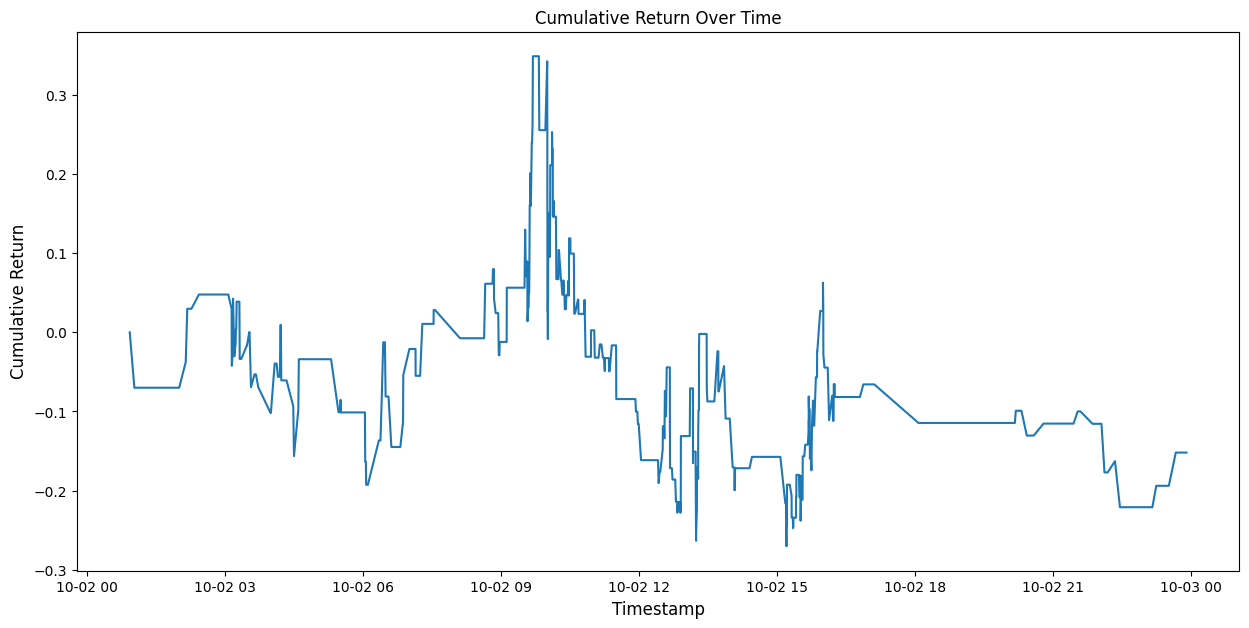

In [28]:
#Plotting the Performance

# Creating a figure and subplot with a specific size
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting the cumulative return
ax.plot(cumulative_return.index, cumulative_return.values)

# Setting the x-axis label and font size
ax.set_xlabel('Timestamp', fontsize=12)

# y-axis label
ax.set_ylabel('Cumulative Return', fontsize=12)

# Set the title of the plot
ax.set_title('Cumulative Return Over Time')

# Display the plot
plt.show()